# Optimality Gap Of LLM-as-policy Reinforcement Algorithms On Gridworld Problem

- Author: Yumo Bai
- Date: Nov 3, 2023
- Email: baiym104@gmail.com

### Installing Packages

In [28]:
!pip install gym
!apt-get install python3-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


### Optimality Gap on the simpler problem

#### Import Packages

In [29]:
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML, Video, clear_output

matplotlib.rcParams['animation.embed_limit'] = 50

#### Building the Environment

In [30]:
SIMP_ENV_NAME = 'Taxi-v3'
RENDER_MODE = 'rgb_array'

Action Space Discrete(6)
State Space Discrete(500)


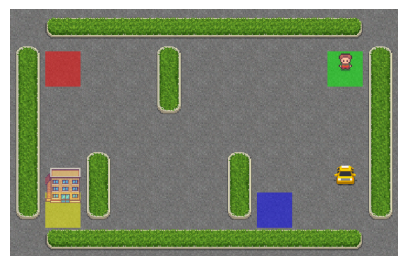

In [31]:
# Canvas for rendering the env
fig, ax = plt.subplots(figsize=(5, 5))

def make_env(env_name, render_mode, seed=42):
  env = gym.make(env_name, new_step_api=True, render_mode=render_mode)
  env.reset(seed=seed)
  init_frame = env.render()[0]

  ax.axis('off')  # Hide the axis
  ax.imshow(init_frame)

  # Show the number of actions and possible states in the environment
  print("Action Space {}".format(env.action_space))
  print("State Space {}".format(env.observation_space))

  return env, init_frame

env, init_frame = make_env(SIMP_ENV_NAME, RENDER_MODE)

#### Random Action Episode

In [32]:
frames = [init_frame]  # List to hold the frames

done = False
truncated = False
while not done and not truncated:
    action = env.action_space.sample()  # Take a random action
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame
    print(state, reward, done, truncated, info)

env.close()  # Don't forget to close the environment

386 -10 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
386 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
386 -10 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
286 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
286 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
286 -10 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
386 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
486 -1 False False {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}
486 -1 False False {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}
486 -1 False False {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}
386 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
286 -1 False False {'prob': 1.0, 'action

In [33]:
def update(frame):
    ax.clear()
    ax.axis('off')  # Hide the axis
    ax.imshow(frame)

ani = FuncAnimation(fig, update, frames=frames, blit=False, interval=100, repeat=False)

ani.save('animation.mp4', writer='ffmpeg', dpi=80)

In [34]:
from base64 import b64encode

# Load the video file and encode it as a base64 string
video_path = 'animation.mp4'
video_file = open(video_path, "rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

# Use the HTML5 video tag to embed the video
HTML(f"""
<video width="640" height="400" controls>
  <source src="{video_url}" type="video/mp4">
</video>
""")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Optimize with Q-Learning

##### Behaviour Exploration

In [15]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Training finished.



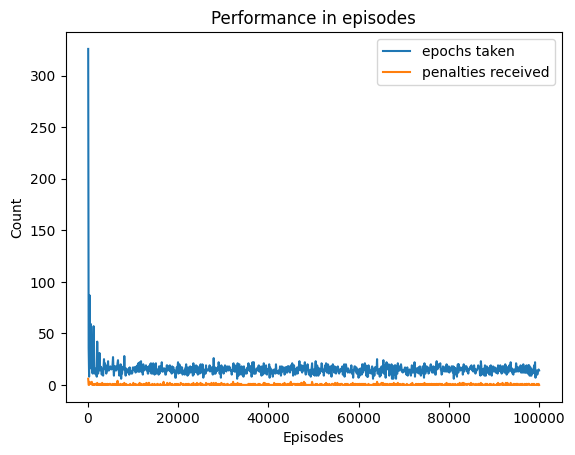

CPU times: user 4h 46min 40s, sys: 31.2 s, total: 4h 47min 11s
Wall time: 4h 49min 18s


In [16]:
%%time
"""Training the agent"""

import random

def q_learning(env, q_table, num_episodes=100000, alpha=0.1, gamma=0.6, epsilon=0.1):

  # For plotting metrics
  episodes = []
  all_epochs = []
  all_penalties = []

  for i in range(1, num_episodes+1):
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
      if random.uniform(0, 1) < epsilon:
          action = env.action_space.sample() # Explore action space
      else:
          action = np.argmax(q_table[state]) # Exploit learned values
      next_state, reward, done, truncated, info = env.step(action)

      old_value = q_table[state, action]
      next_max = np.max(q_table[next_state])

      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
      q_table[state, action] = new_value
      if reward == -10:
          penalties += 1
      state = next_state
      epochs += 1

    if i % 100 == 0:
        print(f"Episode: {i}")
        clear_output(wait=True)
        episodes.append(i)
        all_epochs.append(epochs)
        all_penalties.append(penalties)

  print("Training finished.\n")

  return episodes, all_epochs, all_penalties

episodes, all_epochs, all_penalties = q_learning(env, q_table)

plt.figure()
plt.plot(episodes, all_epochs, label='epochs taken')
plt.plot(episodes, all_penalties, label='penalties received')
plt.title('Performance in episodes')
plt.xlabel('Episodes')
plt.ylabel('Count')
plt.legend()
plt.show()

In [17]:
np.save('q_table.npy', q_table)

from google.colab import files
files.download('q_table.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
q_table = np.load('q_table.npy')
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41837064,  -2.3639511 ,  -2.41837064,  -2.3639511 ,
         -2.27325184, -11.36394725],
       [ -1.870144  ,  -1.45024008,  -1.870144  ,  -1.45024001,
         -0.7504    , -10.45023435],
       ...,
       [ -1.00897079,   0.41599966,  -0.98354117,  -1.09891256,
         -4.07163433,  -4.63241735],
       [ -2.16706467,  -2.12207113,  -2.17063126,  -2.12206944,
         -4.41436947,  -6.76108838],
       [  3.0152869 ,   0.84399347,   3.09857041,  11.        ,
         -2.54830551,  -2.93639053]])

In [10]:
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done, truncated = False, False

    while not done and not truncated:
        action = np.argmax(q_table[state])
        next_state, reward, done, truncated, info = env.step(action)

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Results after 100 episodes:
Average timesteps per episode: 12.75
Average penalties per episode: 0.0


##### Q-Learning Performance

In [22]:
state = env.reset(seed=42)
init_frame = env.render()[0]
frames = [init_frame]  # List to hold the frames

done = False
truncated = False

while not done and not truncated:
    action = np.argmax(q_table[state])  # Take a random action
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame
    print(state, reward, done, truncated, info)

env.close()  # Don't forget to close the environment

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


286 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
186 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
86 -1 False False {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 1, 0], dtype=int8)}
98 -1 False False {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 1], dtype=int8)}
78 -1 False False {'prob': 1.0, 'action_mask': array([1, 0, 1, 1, 0, 0], dtype=int8)}
178 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
278 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
258 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
238 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
218 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
318 -1 False False {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)}
418 -1 False False {'prob': 1.0, 'action_mask'

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))

def update(frame):
    ax.clear()
    ax.axis('off')  # Hide the axis
    ax.imshow(frame)

q_ani = FuncAnimation(fig, update, frames=frames, blit=False, interval=100, repeat=False)

q_ani.save('Q_animation.mp4', writer='ffmpeg', dpi=80)

In [27]:
# Load the video file and encode it as a base64 string
video_path = 'Q_animation.mp4'
video_file = open(video_path, "rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

# Use the HTML5 video tag to embed the video
HTML(f"""
<video width="640" height="400" controls>
  <source src="{video_url}" type="video/mp4">
</video>
""")